Tài liệu này mang giấy phép Creative Commons Attribution (CC BY).
(c) Nguyễn Ngọc Sáng, Zhukovsky 12/2018.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

# Bài 14. Sơ đồ WENO5, phương pháp Runge-Kutta

*Chi Wang Shu:*
- *High Order Weighted Essentially Non-Oscillatory Schemes for Convection Dominated Problem*
- *Essentially Non-Oscillatory and Weighted Essentially Non-Oscillatory Schemes for Hyperbolic Conservation Laws*

## 1. Phép nội suy WENO

Xét lưới đều $x_i = i\Delta x$. Giả sử giá trị hàm u(x) tại mọi điểm lưới đã biết: $u_i = u(x_i)$ Khi đó giá trị xấp xỉ của u(x) tại một điểm bất kì, ví dụ tại $x_{i+1/2}$, có thể xác định được bằng phép nội suy.
Cụ thể, trong `khuôn` (stencil) $S_1 = \{x_{i-2}, x_{i-1}, x_i\}$, tại 3 điểm lưới $i-2, i-1, i$ cho giá trị $u_{i-2}, u_{i-1}, u_i$. Cần tìm đa thức nội suy $p_1(x)$ thỏa mãn: $p_1(x_{i-2}) = u_{i-2},\ p_1(x_{i-1}) = u_{i-1},\ p_1(x_i) = u_i$. Khi đó ta có thể lấy xấp xỉ $u_{i+1/2}^{(1)} = p_1(x_{i+1/2})$.

Sử dụng đa thức nội suy Lagrange, biến đổi ta có $$u_{i+1/2}^{(1)} = \frac{3}{8}u_{i-2} - \frac{5}{4}u_{i-1}+\frac{15}{8}u_i \qquad (1)$$
Xấp xỉ này có độ chính xác bậc ba nếu hàm u(x) trơn trong khuôn $S_1$:
$$u_{i+1/2}^{(1)} - u(x_{i+1/2} = O(\Delta x^3)$$
Tương tự đối với khuôn $S_2 = \{x_{i-1}, x_{i}, x_{i+1}\}$  ta có:
$$u_{i+1/2}^{(2)} = -\frac{1}{8}u_{i-1} + \frac{3}{4}u_{i}+\frac{3}{8}u_{i+1} \qquad (2)$$
khuôn $S_3 = \{x_{i}, x_{i+1}, x_{i+2}\}$:
$$u_{i+1/2}^{(3)} = \frac{3}{8}u_{i} + \frac{3}{4}u_{i+1}-\frac{1}{8}u_{i+2} \qquad (3)$$

Nếu sử dụng khuôn lớn hơn $S = \{x_{i-2}, x_{i-1}, x_{i}, x_{i+1}, x_{i+2}\}$ ta sẽ thu được xấp xỉ có độ chính xác bậc 5:

$u_{i+1/2} = \frac{3}{128}u_{i-2} - \frac{5}{32}u_{i-1}+\frac{45}{64}u_{i} +\frac{15}{32}u_{i+1}-\frac{5}{128}u_{i+2} \qquad (4)$$

Với phép nội suy WENO công thức xấp xỉ (4) bậc 5 trên khuôn lớn S có thể thu được bằng tổ hợp tuyến tính 3 xấp xỉ bậc 3 $u_{i+1/2}^{(1)}, u_{i+1/2}^{(2)}, u_{i+1/2}^{(3)}$ trên 3 khuôn nhỏ $S_1, S_2, S_3$:

$$u_{i+1/2} = \gamma_1 u_{i+1/2}^{(1)} + \gamma_2 u_{i+1/2}^{(2)} +\gamma_3 u_{i+1/2}^{(3)}$$

với các hằng số $\gamma$ thỏa mãn $\gamma_1+\gamma_2+\gamma_3 = 1$ thường được gọi là `*trọng lượng tuyến tính (linear weights)*`, trong trường hợp này:
$$\gamma_1 = 1/16;\ \gamma_2 = 5/8;\ \gamma_3 = 5/16$$

Như vậy nếu hàm u(x) trơn trên khuôn S thì ta sẽ có sơ đồ bậc 5 và cả ba xấp xỉ đều sử dụng được. Trường hợp xuất hiện điểm gián đoạn trong S thì lúc này không phải cả ba xấp xỉ đều tốt. Phương pháp ENO cổ điển sẽ lựa chọn một trong ba xấp xỉ căn cứ vào độ trơn của hàm u(x) trong ba khuôn nhỏ. Với cách đó tại điểm gián đoạn ta vẫn có lời giải với độ chính xác bậc ba và đảm bảo không xuất hiện dao động nếu u(x) trơn trong ít nhất một khuôn nhỏ.

Sơ đồ WENO sử dụng xấp xỉ là tổ hợp ba xấp xỉ bậc ba:
$$u_{i+1/2} = w_1 u_{i+1/2}^{(1)} + w_2 u_{i+1/2}^{(2)} +w_3 u_{i+1/2}^{(3)}$$
với $w_j \geq 0, w_1+w_2+w_3=1$ gọi là `trọng lượng phi tuyến` và thỏa mãn điều kiện:

* $w_j \approx \gamma_j$ if u(x) trơn trong khuôn lớn S
* $w_j \approx 0$ nếu u(x) gián đoạn trên khuôn $S_j$ nhưng trơn trong ít nhất một trong hai khuôn còn lại.

Trọng lượng $w_j$ được xác định căn cứ vào `chỉ thị độ trơn (smoothness indicator)` $\beta_j$ trong khuôn $S_j$. Nếu chỉ thị độ trơn càng lớn thì hàm u(x) càng ít trơn. 

Một trong những công thức xác định chỉ thị độ trơn đó là:
\begin{array}{l}
\beta_1 = \frac{1}{3}\left(4u_{i-2}^2 - 19u_{i-2}u_{i-1} + 25u_{i-1}^2 + 11u_{i-2}u_i - 31u_{i-1}u_i + 10u_i^2 \right)\\
\beta_2 = \frac{1}{3}\left(4u_{i-1}^2 - 13u_{i-1}u_{i} + 13u_{i}^2 + 5u_{i-1}u_{i+1} - 13u_{i}u_{i+1} + 4u_{i+1}^2 \right)\\
\beta_3 = \frac{1}{3}\left(10u_{i-1}^2 - 31u_{i}u_{i+1} + 25u_{i+1}^2 + 11u_{i}u_{i+2} - 19u_{i+1}u_{i+2} + 4u_{i+2}^2\right)
\end{array}
Khi đó, trọng lượng phi tuyến xác định như sau:

$w_j = \frac{\tilde w_j}{\tilde w_1+\tilde w_2+\tilde w_3}$ với $\tilde w_j=\frac{\gamma_j}{(\varepsilon + \beta_j)^2}$

Ở đây $\varepsilon$ có thể lấy bằng 1e-6 nhằm tránh chia cho 0.

# 2. Tái cấu trúc WENO

So với phương pháp nội suy WENO, **phương pháp tái cấu trúc WENO phù hợp hơn để giải các định luật bảo toàn**. Trong phương pháp này, thay vì sử dụng giá trị hàm u(x) tại các điểm lưới ta dùng giá trị trung bình trong thể tích hữu hạn $I_i=(x_{i-1/2}, x_{i+1/2})$: 
$$\overline{u_i} = \frac{1}{\Delta x}\int_{x_{i-1/2}}^{x_{i+1/2}} u(x) dx$$

Cũng như ở phần trước, điều chúng ta muốn là tìm giá trị hàm u(x) tại một điểm cho trước ví dụ tại $x_{i+1/2}$.

Nếu ta định nghĩa một nguyên hàm của u(x):
$$U(x) = \int_{x_{-1/2}}^x u(\xi) d\xi$$
với cận dưới $x_{-1/2}$ có thể thay bởi bất kì điểm cố định nào thì ta có:

$$U(x_{i+1/2} = \int_{x_{-1/2}}^{x_{i+1/2}} u(\xi) d\xi = \sum_{l=0}^i \int_{x_{l-1/2}}^{x_{l+1/2}} u(\xi) d\xi = \sum_{l=0}^i \Delta x \overline{u_l}$$

Như vậy, nếu biết giá trị trung bình u trong mỗi thể tích thì ta sẽ biết giá trị nguyên hàm tại các mặt thể tích $U(x_{i+1/2})$. Giá trị u có thể lấy xấp xỉ $u(x) = U'(x)$. Giả thiết $P_1(x)$ là đa thức nội suy bậc 3 hàm U(x) tại 4 điểm $x_{j+1/2}, j=i-3, i-2, i-1, i$ và $p_1(x)=P'_1(x)$, khi đó $p_1(x)$ là đa thức bậc hai `tái cấu trúc` hàm u(x) trong khuôn $S_1=\{I_{i-2}, I_{i-1}, I_i\}$ với:
$$(\overline{p_1})_j = \frac{1}{\Delta x}\int_{x_{j-1/2}}^{x_{j+1/2}} p_1(x) dx = \overline{u_j}, j=i-2, i-1, i$$ 

Giá trị $u(x_{i+1/2})$ có thể lấy xấp xỉ $u_{i+1/2}^{(1)} \equiv p_1(x_{i+1/2})$. Các phép biến đổi đại số cho ta công thức xấp xỉ bậc 3:
$$u_{i+1/2}^{(1)} = \frac{1}{3}\bar{u}_{i-2} - \frac{7}{6}\bar{u}_{i-1} + \frac{11}{6}\bar{u}_{i} $$
Tương tự cho các khuôn $S_2, S_3$ ta có:
$$u_{i+1/2}^{(2)} = -\frac{1}{6}\bar{u}_{i-1} + \frac{5}{6}\bar{u}_{i} + \frac{1}{3}\bar{u}_{i+1} $$
$$u_{i+1/2}^{(3)} = \frac{1}{3}\bar{u}_{i} + \frac{5}{6}\bar{u}_{i+1} - \frac{1}{6}\bar{u}_{i+2} $$

Nếu sử dụng khuôn lớn $S=\{I_{i-2}, I_{i-1}, I_i, I_{i+1},I_{i+2}\}$ ta có xấp xỉ bậc 5:
$$u_{i+1/2} = \frac{1}{30}\bar{u}_{i-2} - \frac{13}{60}\bar{u}_{i-1} + \frac{47}{60}\bar{u}_{i} + \frac{9}{20}\bar{u}_{i+1} - \frac{1}{20}\bar{u}_{i+2}$$

Tương như phần trước ta có: 
$$u_{i+1/2} = \gamma_1 u_{i+1/2}^{(1)} + \gamma_2 u_{i+1/2}^{(2)} +\gamma_3 u_{i+1/2}^{(3)}$$
với các hằng số:
$$\gamma_1 = 1/10;\ \gamma_2 = 3/5;\ \gamma_3 = 3/10$$

Xấp xỉ cuối cùng được chọn: 
$$u_{i+1/2} = w_1 u_{i+1/2}^{(1)} + w_2 u_{i+1/2}^{(2)} +w_3 u_{i+1/2}^{(3)}$$

Với chỉ thị độ trơn:

\begin{array}{l}
\beta_1 = \frac{13}{12}\left(\bar{u}_{i-2} - 2\bar{u}_{i-1}+\bar{u}_{i}\right)^2 + \frac{1}{4}\left(\bar{u}_{i-2} - 4\bar{u}_{i-1}+3\bar{u}_{i}\right)^2\\
\beta_2 = \frac{13}{12}\left(\bar{u}_{i-1} - 2\bar{u}_{i}+\bar{u}_{i+1}\right)^2 + \frac{1}{4}\left(\bar{u}_{i-1} - \bar{u}_{i+1}\right)^2\\
\beta_3 = \frac{13}{12}\left(\bar{u}_{i} - 2\bar{u}_{i+1}+\bar{u}_{i+2}\right)^2 + \frac{1}{4}\left(3\bar{u}_{i} - 4\bar{u}_{i+1}+\bar{u}_{i+2}\right)^2
\end{array}


**Sử dụng tính chất đối xứng ta có công thức xác định giá trị $u_{i-1/2}$ như sau:**
$$u_{i-1/2}^{(1)} = -\frac{1}{6}\bar{u}_{i-2} + \frac{5}{6}\bar{u}_{i-1} + \frac{1}{3}\bar{u}_{i} $$
$$u_{i-1/2}^{(2)} = \frac{1}{3}\bar{u}_{i-1} + \frac{5}{6}\bar{u}_{i} - \frac{1}{6}\bar{u}_{i+1} $$
$$u_{i-1/2}^{(3)} = \frac{11}{6}\bar{u}_{i} - \frac{7}{6}\bar{u}_{i+1} + \frac{1}{3}\bar{u}_{i+2} $$

$$\gamma_1 = 3/10;\ \gamma_2 = 3/5;\ \gamma_3 = 1/10$$

## 3. Sơ đồ sai phân phương pháp thể tích hữu hạn

Xét phương trình Burgers không nhớt:
$$\frac {\partial u}{\partial t} + \frac{\partial F}{\partial x} = 0; \ F=\frac{u^2}{2} \qquad (1)$$

với sơ đồ sai phân phương pháp thể tích hữu hạn:
$$\frac {d\bar{u}}{dt} + \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x} = 0 \qquad(2)$$


Cũng giống như phương pháp Godunov hay MUSCL trong bài 12, 13 chúng ta sẽ giải phương trình Burgers theo ba bước:
* 1. sử dụng xấp xỉ bậc 5 WENO để tái cấu trúc nghiệm trong từng cell, tìm $u_{i+1/2}^L, u_{i+1/2}^R$. Giá trị uL bên trái được xác định bằng xấp xỉ trong khuôn $S_L = \{I_{i-2}, I_{i-1}, I_{i}, I_{i+1}, I_{i+2}\}$. Tương ứng uR - $S_R = \{I_{i-1}, I_{i}, I_{i+1}, I_{i+2}, I_{i+3}\}$. Như vậy ta có giá trị $u_{i+1/2}^L = u_{i+1/2}, u_{i+1/2}^R = u_{(i+1)-1/2}$.

<img src='img/Bai_14.png'>

* 2. tìm nghiệm bài toán phân rã gián đoạn trên bề mặt $i+1/2$, tính hàm dòng.
* 3. tìm nghiệm u ở bước thời gian tiếp theo bằng phương pháp Runge-Kutta bậc ba:

    - viết lại phương trình Burgers ở dạng:
$$\frac {\partial u}{\partial t} = L(u)$$
với toán tử $L(u) = -\frac{\partial F}{\partial x}$.

    - rời rạc thời gian theo ba bước:
\begin{array}{l}
\bar{u}^{(1)} = \bar{u}^n + \Delta t L(\bar{u}^n)\\
\bar{u}^{(2)} = \frac{3}{4}\bar{u}^n + \frac{1} {4}\bar{u}^{(1)} + \frac{1}{4} \Delta t L(\bar{u}^{(1)})\\
\bar{u}^{n+1} = \frac{1}{3}\bar{u}^n + \frac{2}{3}\bar{u}^{(2)} + \frac{2}{3} \Delta t L(\bar{u}^{(2)})
\end{array}


**Bài toán**

Như ở hai bài trước, ta xét hai bài toán lan truyền sóng xung kích và sóng phân rã trong thời gian dao động còn chưa lan truyền tới biên. Xem như điều kiện trên biên u không đổi. Với các công thức tính xấp xỉ u, ta cần 2 ô trên biên trái và 3 ô trên biên phải. Tức vùng tính toán: $x[2:-3]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


#WENO5 Interpolation: smothness indicators
def beta_Itp(a, u):
    b = 1./3*(a[0]*u[0]**2 + a[1]*u[0]*u[1] + a[2]*u[1]**2 + a[3]*u[0]*u[2] + a[4]*u[1]*u[2] + a[5]*u[2]**2)
    return b

#WENO5 Reconstruction: smothness indicators
def beta_Rct(a, u):
    b = 13./12*(u[0] - 2*u[1] + u[2])**2 + 0.25*(a[0]*u[0] + a[1]*u[1] + a[2]*u[2])**2
    return b

#Hàm tìm trọng lượng phi tuyến 
def omega(gamma, beta):
    omgs = gamma/(epsilon + beta)**2
    omgs_sum = sum(omgs)
    omg = omgs/omgs_sum
    return omg

#Hàm tái cấu trúc nghiệm
def reconstruction(u, beta, a_b, gamma, a_u, u_05):
    for i in range(2, len(u)-2): #for each cell in cells
        #bước 1. tính chỉ thị độ trơn trong từng khuôn S_j
        b0 = beta(a_b[0], u[i-2:i+1])
        b1 = beta(a_b[1], u[i-1:i+2])
        b2 = beta(a_b[2], u[i  :i+3])
        
        #bước 2. tìm trọng lượng phi tuyến từng khuôn
        omg = omega(gamma, np.array([b0, b1, b2]))
        
        #bước 3. tìm xấp xỉ bậc 3
        u0 = sum(a_u[0] * u[i-2:i+1])
        u1 = sum(a_u[1] * u[i-1:i+2])
        u2 = sum(a_u[2] * u[i  :i+3])
        
        #bước 4. tìm xấp xỉ bậc 5
        u_05[i] = sum(omg * [u0, u1, u2])
        
        #Điều kiện biên: u_05[0], u_05[1], u_05[-2], u_05[-1]
    return

#Phân rã gián đoạn godunov trên từng mặt thể tích hữu hạn 
def decay_godunov(ul, ur): #uL, uR là hai số
    ustar = 0
    if ul > ur:
        if (ul + ur)/2. > 0: ustar = ul
        else: ustar = ur
    else:
        if ul > 0: ustar = ul
        elif ur < 0: ustar = ur
        else: ustar = 0
    return ustar

def flux(u):
    return u**2/2.

#solver
def solver(u, beta, a_b, gamma_p05, gamma_m05, a_up05, a_um05, nt):
    u_p05 = u.copy()
    u_m05 = u.copy()
    un   = u.copy()
    for n in range(nt):
        un = u.copy()
        for stage in range(3): #runge-kutta 3
            #Step 1: reconstruction u_{i+1/2}, u_{i-1/2}
            reconstruction(u, beta, a_b, gamma_p05, a_up05, u_p05)
            reconstruction(u, beta, a_b, gamma_m05, a_um05, u_m05)

            #Step 2: riemann solver
            ustar = np.array([decay_godunov(ul, ur) for ul, ur in zip(u_p05[1:-2], u_m05[2:-1])])

            #Step 3: time intergration
            if stage == 0: u[2:-2] = un[2:-2] - dt/dx*(flux(ustar[1:]) - flux(ustar[:-1]))
            elif stage == 1: u[2:-2] = 0.75*un[2:-2] + 0.25*u[2:-2] - 0.25*dt/dx*(flux(ustar[1:]) - flux(ustar[:-1]))
            else: u[2:-2] = 1./3*un[2:-2] + 2./3*u[2:-2] - 2./3*dt/dx*(flux(ustar[1:]) - flux(ustar[:-1]))
            #điều kiện biên u[0], u[1], u[-2], u[-1]
    return 

# 1. WENO5 Interpolation
#các hệ số trong công thức chỉ thị độ trơn 
a_b0 = [4., -19., 25., 11., -31., 10.]
a_b1 = [4., -13., 13., 5., -13., 4.]
a_b2 = [10., -31., 25., 11., -19., 4.]
a_bItp  = [a_b0, a_b1, a_b2]

#tái cấu trúc u_{i+1/2}
#trọng lượng tuyến tính 
gamma_Itp_p05 = np.array([1./16, 5./8, 5./16])

#các hệ số trong công thức xấp xỉ bậc ba 
a_u0 = [3./8, -5./4, 15./8]
a_u1 = [-1./8, 3./4, 3./8]
a_u2 = [3./8, 3./4, -1./8]
a_uItp_p05  = [a_u0, a_u1, a_u2]

#tái cấu trúc u_{i-1/2}
gamma_Itp_m05 = np.array([5./16, 5./8, 1./16])

#các hệ số trong công thức xấp xỉ bậc ba 
a_u0 = [-1./8, 3./4, 3./8]
a_u1 = [3./8, 3./4, -1./8]
a_u2 = [15./8, -5./4, 3./8]
a_uItp_m05  = [a_u0, a_u1, a_u2]


# 2. WENO5 Reconstruction
a_b0 = [1., -4., 3.]
a_b1 = [1., 0., -1.]
a_b2 = [3., -4., 1.]
a_bRct = [a_b0, a_b1, a_b2]

#reconstruction u_{i+1/2}
gamma_Rct_p05 = np.array([1./10, 3./5, 3./10])

a_u0 = [1./3, -7./6, 11./6]
a_u1 = [-1./6, 5./6, 1./3]
a_u2 = [1./3, 5./6, -1./6]
a_uRct_p05  = [a_u0, a_u1, a_u2]

#reconstruction u_{i-1/2}
gamma_Rct_m05 = np.array([3./10, 3./5, 1./10])

a_u0 = [-1./6, 5./6, 1./3]
a_u1 = [1./3, 5./6, -1./6]
a_u2 = [11./6, -7./6, 1./3]
a_uRct_m05  = [a_u0, a_u1, a_u2]

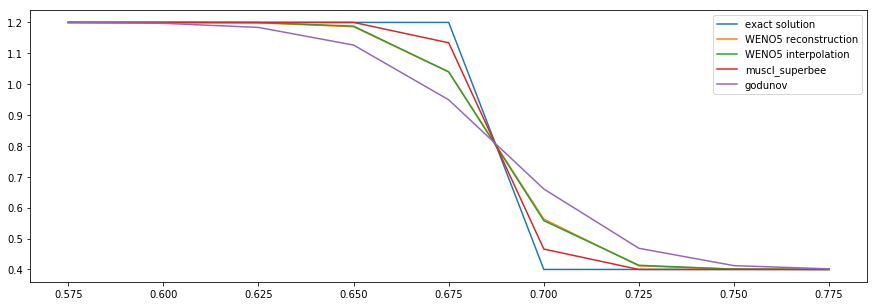

In [2]:
#chia lưới 
nx = 41
x, dx = np.linspace(0, 1, nx, retstep=True)
r = 0.4
dt = r*dx
nt = 25
epsilon = 1e-6

#điều kiện ban đầu
uL = 1.2
uR = 0.4
i = int(0.5/dx)
u0 = np.zeros(nx)
u0[:i] = uL
u0[i:] = uR


u_weno5_Rct = u0.copy()
solver(u_weno5_Rct, beta_Rct, a_bRct, gamma_Rct_p05, gamma_Rct_m05, a_uRct_p05, a_uRct_m05, nt)
 
u_weno5_Itp = u0.copy()
solver(u_weno5_Itp, beta_Itp, a_bItp, gamma_Itp_p05, gamma_Itp_m05, a_uItp_p05, a_uItp_m05, nt)

#tải nghiệm muscl superbee ở bài 13
u_muscl = np.genfromtxt('data/burgers_muscl_test1.dat')

#tải nghiệm sơ đồ godunov ở bài 12
u_godunov = np.genfromtxt('data/burgers_godunov_test1.dat')


#nghiệm chính xác: vận tốc lan truyền sóng xung kích s=(uL+uR)/2. = 0.8
u_exact = np.zeros(nx)
i = int((0.5 + 0.8*nt*dt)/dx)
u_exact[:i] = uL
u_exact[i:] = uR

fig = plt.figure(figsize=[15, 5])
i = int(0.6/dx)
j = int(0.8/dx)

plt.plot(x[i:j], u_exact[i:j], x[i:j], u_weno5_Rct[i:j])
plt.plot(x[i:j], u_weno5_Itp[i:j], x[i:j], u_muscl[i:j], x[i:j], u_godunov[i:j])
plt.legend(['exact solution', 'WENO5 reconstruction', 'WENO5 interpolation', 'muscl_superbee', 'godunov'])
plt.show()

Kết quả cho ta thấy, WENO5 nội suy và tái cấu trúc cho kết quả gần như nhau. Sự khác biệt giữa hai sơ đồ, như đã nói ở trên, sẽ rõ ràng hơn khi áp dụng cho bài toán bảo toàn. Mặt khác ta thấy sơ đồ superbee cho kết quả tốt hơn, tuy nhiên theo như kết quả ở bài 13, mỗi sơ đồ cho độ chính xác khác nhau với từng bài toán khác nhau. Do đó cần nghiên cứu để lựa chọn sơ đồ tốt nhất phù hợp với bài toán. 

Tiếp theo ta xét bài toán sóng giãn.

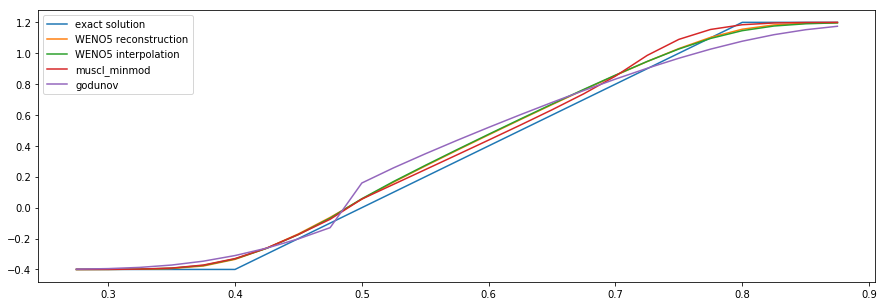

In [3]:
#xét bài toán sóng giãn
uL = -0.4 # <0 - dịch chuyển sang trái
uR = 1.2  # >0 - dịch chuyển sang phải 

u0 = np.zeros(nx)
i = int(0.5/dx)
u0[:i] = uL
u0[i:] = uR

u_weno5_Rct = u0.copy()
solver(u_weno5_Rct, beta_Rct, a_bRct, gamma_Rct_p05, gamma_Rct_m05, a_uRct_p05, a_uRct_m05, nt)
 
u_weno5_Itp = u0.copy()
solver(u_weno5_Itp, beta_Itp, a_bItp, gamma_Itp_p05, gamma_Itp_m05, a_uItp_p05, a_uItp_m05, nt)

#tải nghiệm muscl superbee ở bài 13
u_muscl = np.genfromtxt('data/burgers_muscl_test2.dat')

#tải nghiệm sơ đồ godunov ở bài 12
u_godunov = np.genfromtxt('data/burgers_godunov_test2.dat')

u_exact = u0.copy()
t = nt*dt
i = int((0.5 + uL*t)/dx)
j = int((0.5 + uR*t)/dx)
for k in range(i+1, j): u_exact[k] = (x[k]-0.5)/t
    
ig = plt.figure(figsize=[15, 5])
i = int(0.3/dx)
j = int(0.9/dx)
plt.plot(x[i:j], u_exact[i:j], x[i:j], u_weno5_Rct[i:j])
plt.plot(x[i:j], u_weno5_Itp[i:j], x[i:j], u_muscl[i:j], x[i:j], u_godunov[i:j])
plt.legend(['exact solution', 'WENO5 reconstruction', 'WENO5 interpolation', 'muscl_minmod', 'godunov'])
plt.show()

Trong trường hợp này sơ đồ WENO5 cho kết quả tốt nhất. Để có cái nhìn tổng quan hơn về 3 sơ đồ này ta sẽ so sánh thêm ở bài 15.

### [Bài 15. So sánh sơ đồ Godunov, MUSCL, WENO5](Bai_15.ipynb)